# Fisher Information Continued

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf

import torch

In [2]:
# load the trained model
from datageneration.stimulusGeneration import generateGrating
from basicModel import EstimateAngle

from experiments.ex2_sensitivity_scaling import dataFile_Experiment2

# training data parameters
pixelDim = 101
shotNoise = 0.8
noiseVar = 20

# training data distribution
dataSize = 512
kappa_tr = 4.
loc_tr = 0.
rep = 0


fileName = dataFile_Experiment2(dataSize, kappa_tr, loc_tr, rep)
trained_model = EstimateAngle.load_from_checkpoint(fileName)

## Continued experiments for smooth, efficient Fisher information determination 

### Can we use the noise free stimuli to measure the mean response?

In [3]:
angles = np.linspace(0., np.pi, 21)

noise_free_results = trained_model.forward(
                generateGrating(angles, pixelDim=pixelDim, shotNoise=0., noiseVar=0.)
             )


means = []
vars = []

for angle in angles:
    noisy_results = trained_model.forward(
                            generateGrating(1000*[angle], pixelDim=pixelDim, shotNoise=shotNoise,
                                            noiseVar=noiseVar)
                    )

    m = noisy_results.mean(0)
    CV = torch.cov(noisy_results.T)


    means.append(m.detach().numpy())
    vars.append(CV.detach().numpy())


In [4]:
means = np.array(means)
vars = np.array(vars)
noise_free_results = noise_free_results.detach().numpy()

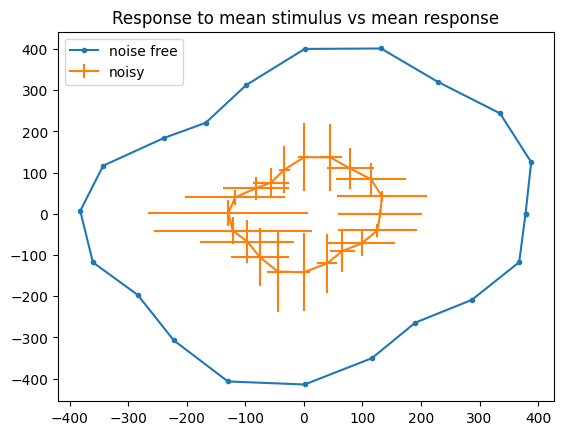

In [5]:
plt.plot(noise_free_results[:,0], noise_free_results[:,1], '.-', label='noise free')
plt.errorbar( means[:, 0], means[:,1], xerr=vars[:,0,0], yerr=vars[:,1,1], label='noisy')
plt.legend()
_=plt.title('Response to mean stimulus vs mean response')

This is quite interesting. The noise free image produces a _much larger_ response from the network.

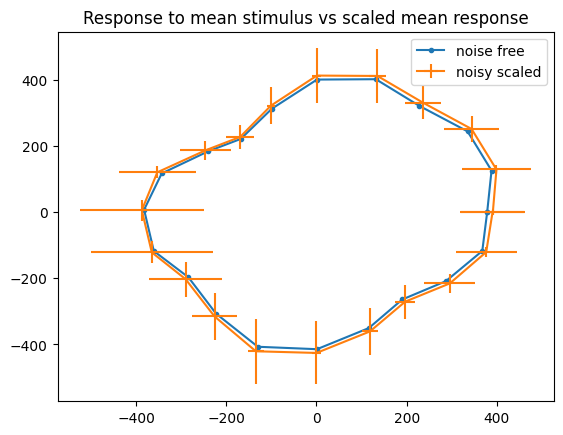

In [6]:
plt.plot(noise_free_results[:,0], noise_free_results[:,1], '.-', label='noise free')
plt.errorbar( 3*means[:, 0], 3*means[:,1], xerr=vars[:,0,0], yerr=vars[:,1,1], label='noisy scaled')
plt.legend()
_=plt.title('Response to mean stimulus vs scaled mean response')

It is very close to just a 3x scaling.

In [7]:
low_rate_means = []
low_rate_vars = []

low_size_means = []
low_size_vars = []

for angle in angles:
    noisy_results_rate = trained_model.forward(
                            generateGrating(1000*[angle], pixelDim=pixelDim, shotNoise=shotNoise/2,
                                            noiseVar=noiseVar)
                    )

    low_rate_means.append( noisy_results_rate.mean(0).detach().numpy() )
    low_rate_vars.append(torch.cov(noisy_results_rate.T).detach().numpy())

    noisy_results_size = trained_model.forward(
                            generateGrating(1000*[angle], pixelDim=pixelDim, shotNoise=shotNoise,
                                            noiseVar=noiseVar/2)
                    )

    low_size_means.append( noisy_results_size.mean(0).detach().numpy() )
    low_size_vars.append(torch.cov(noisy_results_size.T).detach().numpy() )
    

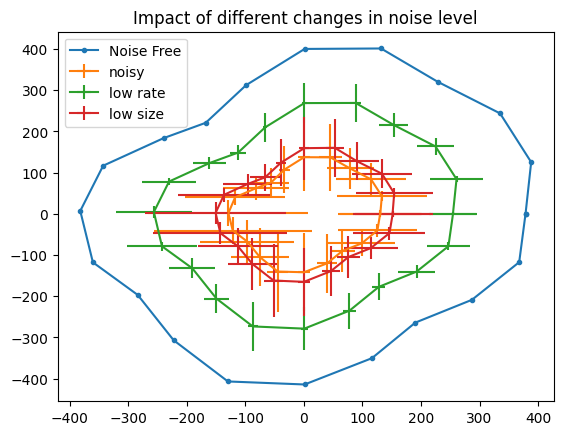

In [8]:
low_rate_means = np.array(low_rate_means)
low_rate_vars = np.array(low_rate_vars)

low_size_means = np.array(low_size_means)
low_size_vars = np.array(low_size_vars)


plt.plot(noise_free_results[:,0], noise_free_results[:,1], '.-', label='Noise Free')
plt.errorbar( means[:, 0], means[:,1],
             xerr=vars[:,0,0], yerr=vars[:,1,1], label='noisy')
plt.errorbar(low_rate_means[:, 0], low_rate_means[:,1],
             xerr=low_rate_vars[:,0,0], yerr=low_rate_vars[:,1,1], label='low rate')
plt.errorbar(low_size_means[:, 0], low_size_means[:,1],
             xerr=low_size_vars[:,0,0], yerr=low_size_vars[:,1,1], label='low size')

plt.legend()

_=plt.title('Impact of different changes in noise level')

The noise rate has a much larger impact. This is not totally surprising given how the data is generated.

__Question__: Does this size scaling act as a a form of 'certainty coding' in this network?  
More noise -> smaller scale and vice versa. This is an interesting direction that I won't follow up on right now.
- does it show up at different levels of noise?
- does it show up with different input distributions?


__another interesting feature__: The variance is usually perpendicular to the curve.  
This makes total sense from our Fisher information viewpoint.

#### Can we use the noise-free samples as a proxy for the noisy means?

If noise-free is truly a multiple of the mean output, then this should be just fine. The additional multiplicative factor will be absorbed into the normalization anyway.

#### The size of the error bars:

These error bars are the variances of the samples. There are 1000 samples, so the error of the mean should be ~32 times smaller than the error bars pictured.

<ErrorbarContainer object of 3 artists>

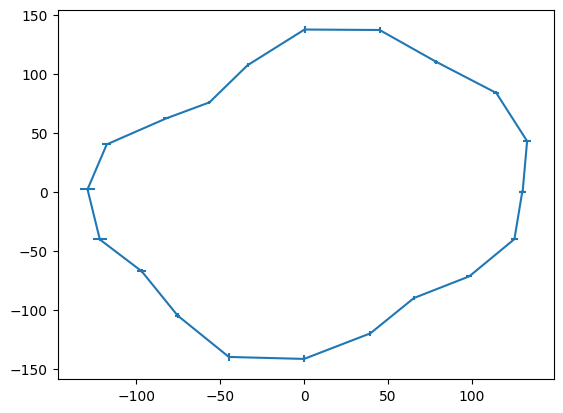

In [9]:
plt.errorbar( means[:, 0], means[:,1], xerr=vars[:,0,0]/1000**0.5, yerr=vars[:,1,1]/1000**0.5, label='noisy')

In this view, the mean of the samples should be basically just as good as the noise free outputs for evaluating derivatives!

Unless, the error of the mean calculations aren't accurately representing the variance of our calculated means.

In [10]:
angle = 0.22

means_22 = []
vars_22 = []


for rep in range(200):
    noisy_results = trained_model.forward(
                                generateGrating(1000*[angle], pixelDim=pixelDim,
                                                shotNoise=shotNoise, noiseVar=noiseVar)
                        )

    means_22.append(noisy_results.mean(0).detach().numpy())
    vars_22.append(torch.cov(noisy_results.T).detach().numpy())


means_22 = np.array(means_22)
vars_22 = np.array(vars_22)


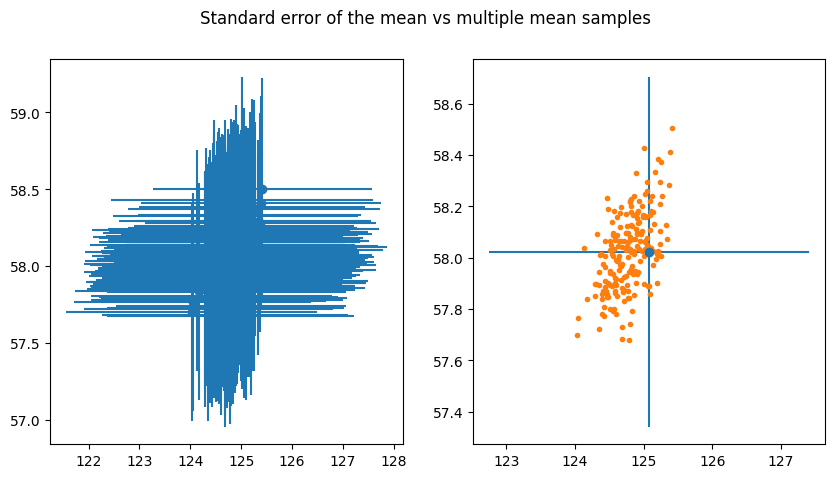

In [25]:
figsize(10, 5)
plt.subplots(1,2)
plt.suptitle('Standard error of the mean vs multiple mean samples')

plt.subplot(1,2,1)
plt.errorbar(means_22[:,0], means_22[:,1], xerr=vars_22[:,0,0]/1000**0.5, yerr=vars_22[:,1,1]/1000**0.5, fmt='o')

plt.subplot(1,2,2)
plt.errorbar(means_22[0,0], means_22[0,1], xerr=vars_22[0,0,0]/1000**0.5, yerr=vars_22[0,1,1]/1000**0.5, fmt='o')
plt.plot(means_22[1:,0], means_22[1:, 1], '.')

Ok. That is really nice to see! The standard error of the mean matches reasonably well to the variance that we observe with multiple samplings of the mean.

This is expected unless there is gross non-normality of the data that we are averaging over. Possible here, but comforting to see that this is not the case.

#### Noise-free input conclusions:

Noise free inputs show similar dependence to noise-less inputs, but at a much larger scale.
However, closer examination of the mean samples show that the variance of the means shouldn't be all that large relative to the overall changes in mean.  
Overall, I think that switching to the (less-reliable) noise-free inputs won't fit the problems that we have with the derivatives.


In [28]:
angles = np.linspace(0.20, 0.3, 20)

means_small = []
vars_small = []


for angle in angles:
    noisy_results = trained_model.forward(
                                generateGrating(1000*[angle], pixelDim=pixelDim,
                                                shotNoise=shotNoise, noiseVar=noiseVar)
                        )

    means_small.append(noisy_results.mean(0).detach().numpy())
    vars_small.append(torch.cov(noisy_results.T).detach().numpy())


means_small = np.array(means_small)
vars_small = np.array(vars_small)

<ErrorbarContainer object of 3 artists>

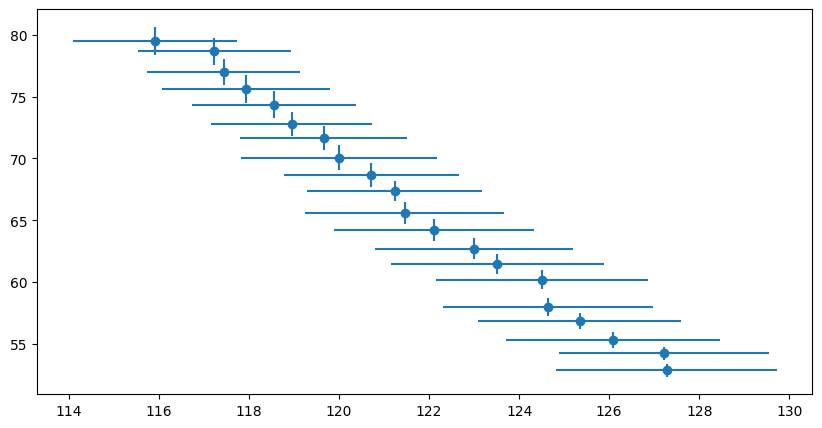

In [29]:
plt.errorbar(means_small[:,0], means_small[:,1],
             xerr=vars_small[:,0,0]/1000**0.5, yerr=vars_small[:,1,1]/1000**0.5, fmt='o')

Yeah, ok, so it does become an issue at smaller distances...

### Before we go too deep, lets try a couple of out of the box methods.

In [4]:
# methods from stack overflow:
from scipy.signal import savgol_filter
from scipy.interpolate import splev
# total variance regularization


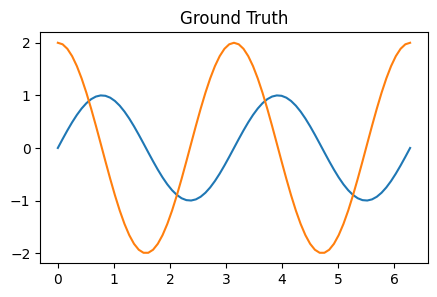

In [6]:
x = np.linspace(0, 2*np.pi, 75)

y_gt = np.sin(2*x)
deriv_gt = 2*np.cos(2*x)

figsize(5, 3)
plt.plot(x, y_gt)
plt.plot(x, deriv_gt)
_=plt.title('Ground Truth')

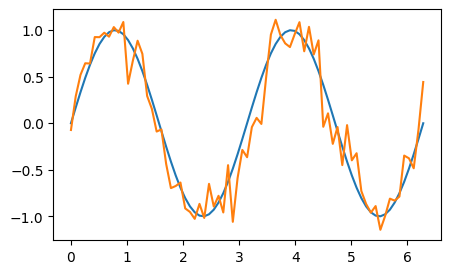

In [7]:
y_noisy = y_gt + 0.2*np.random.randn(*y_gt.shape)
plt.plot(x, y_gt)
plt.plot(x, y_noisy)

#### B-spline

__Summary__: As usual with splines, the primary objective here seems to be computation of the values of tabulated functions. That is to say, we have a well-behaved function whose values we know at some locations. Splines allow us to construct numerical representations of that function that can be evaluated at any point, and give a response that is guaranteed to be at least reasonable.

In [57]:
from scipy.interpolate import splev, splrep

# note, the kwarg s offers a degree of smoothing 

In [59]:
myspline_gt = splrep(x, y_gt)
myspline_noisy = splrep(x, y_noisy)

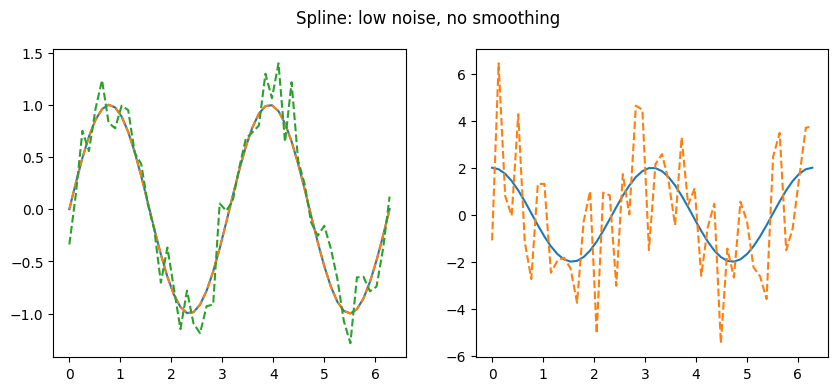

In [72]:
figsize(10, 4)
plt.subplots(1,2)

plt.suptitle('Spline: low noise, no smoothing')

plt.subplot(1,2,1)
plt.plot(x, y_gt)
plt.plot(x, splev(x, tck=myspline_gt), '--')
plt.plot(x, splev(x, tck=myspline_noisy), '--')

plt.subplot(1,2,2)
plt.plot(x, deriv_gt)
plt.plot(x, splev(x, tck=myspline_noisy, der=1), '--')

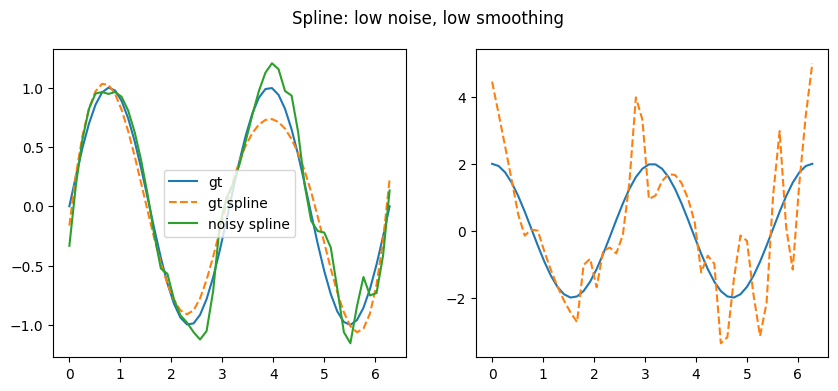

In [90]:
myspline_gt = splrep(x, y_gt, s=1)
myspline_noisy = splrep(x, y_noisy, s=1)

figsize(10, 4)
plt.subplots(1,2)

plt.suptitle('Spline: low noise, low smoothing')

plt.subplot(1,2,1)
plt.plot(x, y_gt, label='gt')
plt.plot(x, splev(x, tck=myspline_gt), '--', label='gt spline')
plt.plot(x, splev(x, tck=myspline_noisy), label='noisy spline')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x, deriv_gt)
plt.plot(x, splev(x, tck=myspline_noisy, der=1), '--')

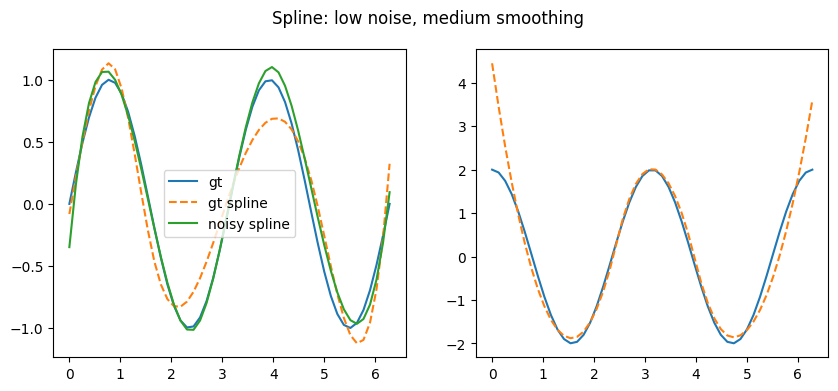

In [86]:
myspline_gt = splrep(x, y_gt, s=2)
myspline_noisy = splrep(x, y_noisy, s=2)

figsize(10, 4)
plt.subplots(1,2)

plt.suptitle('Spline: low noise, medium smoothing')

plt.subplot(1,2,1)
plt.plot(x, y_gt, label='gt')
plt.plot(x, splev(x, tck=myspline_gt), '--', label='gt spline')
plt.plot(x, splev(x, tck=myspline_noisy), label='noisy spline')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x, deriv_gt)
plt.plot(x, splev(x, tck=myspline_noisy, der=1), '--')

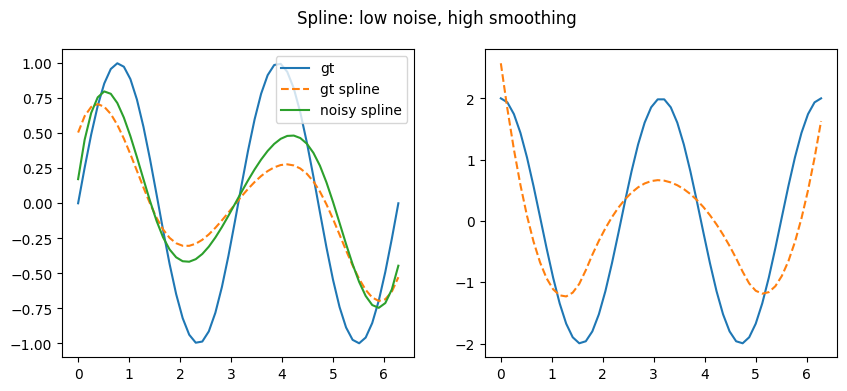

In [88]:
myspline_gt = splrep(x, y_gt, s=10)
myspline_noisy = splrep(x, y_noisy, s=10)

figsize(10, 4)
plt.subplots(1,2)

plt.suptitle('Spline: low noise, high smoothing')

plt.subplot(1,2,1)
plt.plot(x, y_gt, label='gt')
plt.plot(x, splev(x, tck=myspline_gt), '--', label='gt spline')
plt.plot(x, splev(x, tck=myspline_noisy), label='noisy spline')
plt.legend()

plt.subplot(1,2,2)
plt.plot(x, deriv_gt)
plt.plot(x, splev(x, tck=myspline_noisy, der=1), '--')

Ok, there we have it. Adjusting the smoothing, we can get reasonably smooth curves at the price of worse fits. Pretty much the same thing happens for the derivatives.

One advantage that we would have in this application is that the circular domain would allow us to treat every point as a 'middle' point, which seem to see better fits that the edges.

Also note that `splprep` lets us fit multidimensional splines.

#### Savitzky–Golay filter

__Summary__:  The approach uses local least squares polynomial fits to the curve, and then evaluates their derivatives. At least this way there should be some noise control. Generally, the purpose of this method seems to be finding zeros of derivatives. 

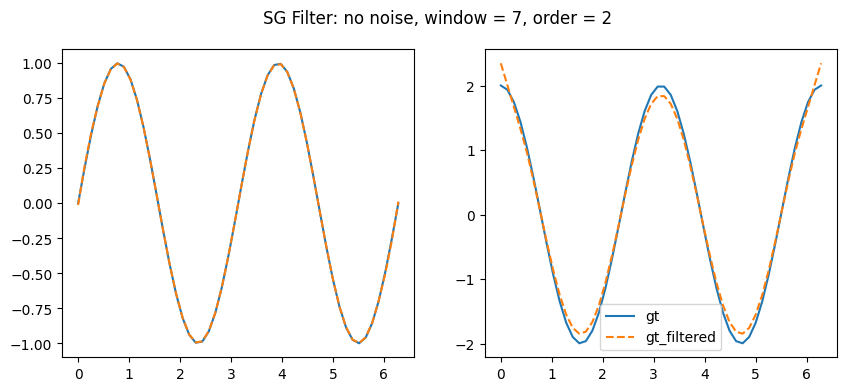

In [225]:
from scipy.signal import savgol_filter

window = 7
order = 2

figsize(10, 4)
plt.subplots(1,2)

plt.suptitle(f'SG Filter: no noise, window = {window}, order = {order}')

plt.subplot(1,2,1)
plt.plot(x, y_gt)
plt.plot(x, savgol_filter(y_gt, window_length=window, polyorder=order), '--')

plt.subplot(1,2,2)
plt.plot(x, deriv_gt, label='gt')
plt.plot(x, savgol_filter(y_gt, window_length=window, polyorder=order, deriv=1, delta=x[2] - x[1]), '--', label='gt_filtered')
plt.legend()

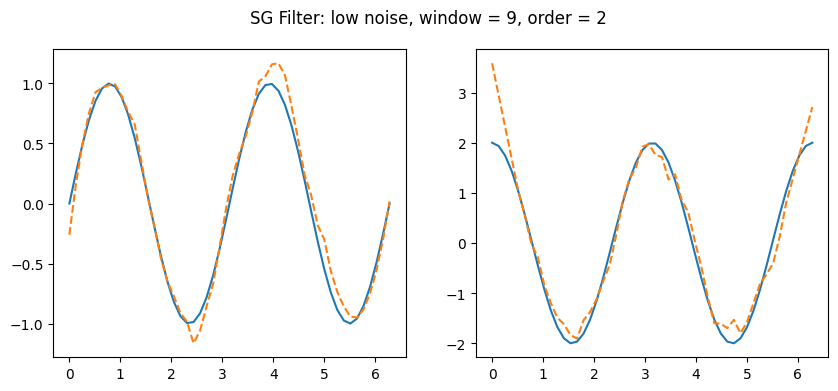

In [230]:
figsize(10, 4)
plt.subplots(1,2)

window = 9
order = 2

plt.suptitle(f'SG Filter: low noise, window = {window}, order = {order}')

plt.subplot(1,2,1)
plt.plot(x, y_gt)
plt.plot(x, savgol_filter(y_noisy, window_length=window, polyorder=order), '--')

plt.subplot(1,2,2)
plt.plot(x, deriv_gt, label='gt')
plt.plot(x, savgol_filter(y_noisy, window_length=window, polyorder=order, deriv=1, delta=x[2] - x[1]), '--', label='noisy_filtered')


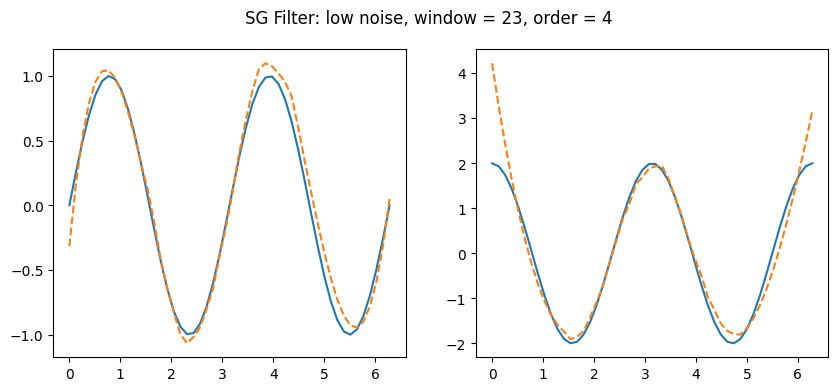

In [382]:
figsize(10, 4)
plt.subplots(1,2)

window = 23
order = 4

plt.suptitle(f'SG Filter: low noise, window = {window}, order = {order}')

plt.subplot(1,2,1)
plt.plot(x, y_gt)
plt.plot(x, savgol_filter(y_noisy, window_length=window, polyorder=order), '--')

plt.subplot(1,2,2)
plt.plot(x, deriv_gt, label='gt')
plt.plot(x, savgol_filter(y_noisy, window_length=window, polyorder=order, deriv=1, delta=x[2] - x[1]), '--', label='noisy_filtered')


Ok, it is quite sensitive to the parameters. Generally,

1. Increased polynomial order results in greater noise sensitivity of the fits.
2. Increased window length behaves like increased regularization: it smoothes the fits at the cost of delaying the trajectories in time and pushing the derivatives toward zero.
3. For noise-free data, odd window sizes are clearly better than even window sizes. This makes sense: they are centered on the points in question.


In this particular case, the fits seem less good than the smoothed spline interpolation, in particular toward middle of the range, where the spline fits look very good.

#### Total variation regularization 

__Summary__: This approach directly optimizes the reconstruction of the original data under total variation (ie L1) regularization. As such, it is optimized to detect functions that have large changes in derivatives.

In [13]:
from tvregdiff.tvregdiff import TVRegDiff

First of all, note that the dx parameter is crucial to get the scale correct!

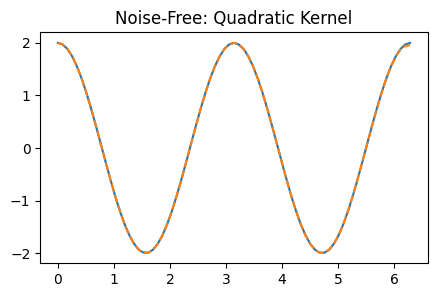

In [14]:
fits = TVRegDiff(y_gt, 400, 0.001, plotflag=False, diffkernel='sq', dx=x[1] -x[0])


plt.title('Noise-Free: Quadratic Kernel')
plt.plot(x, deriv_gt)
plt.plot(x, fits,'--')

In [15]:
figsize(5,4)

fits = TVRegDiff(y_gt, 400, 0.01, plotflag=False, dx=x[1] -x[0])

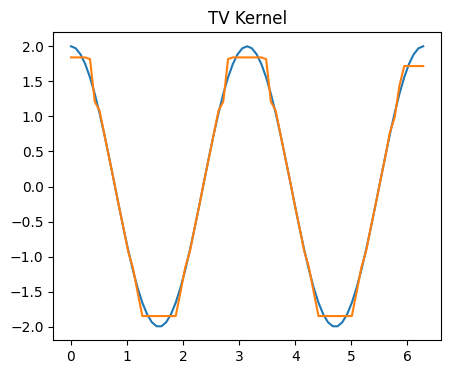

In [16]:
plt.title('TV Kernel')
plt.plot(x, deriv_gt)
plt.plot(x, fits)

This method is optimized for use with discontinuous derivatives... but it seems to see them everywhere, and force the outputs to be blocky.

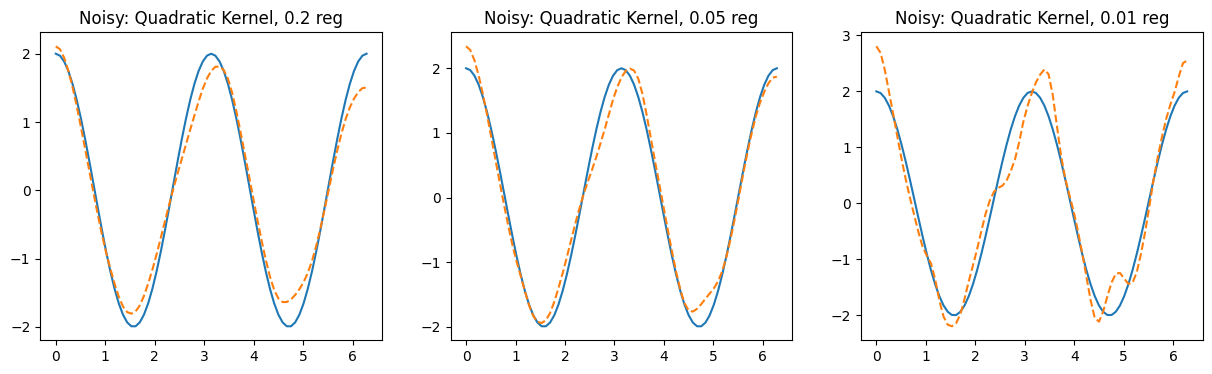

In [19]:
figsize(15, 4)
plt.subplots(1,3)

plt.subplot(1,3,1)
fits = TVRegDiff(y_noisy, 400, 0.1, plotflag=False, diffkernel='sq', dx=(x[1] -x[0]) )
plt.title('Noisy: Quadratic Kernel, 0.2 reg')
plt.plot(x, deriv_gt)
plt.plot(x, fits,'--')

plt.subplot(1,3,2)
fits = TVRegDiff(y_noisy, 400, 0.05, plotflag=False, diffkernel='sq', dx=(x[1] -x[0]) )
plt.title('Noisy: Quadratic Kernel, 0.05 reg')
plt.plot(x, deriv_gt)
plt.plot(x, fits,'--')

plt.subplot(1,3,3)
fits = TVRegDiff(y_noisy, 400, 0.01, plotflag=False, diffkernel='sq', dx=(x[1] -x[0]) )
plt.title('Noisy: Quadratic Kernel, 0.01 reg')
plt.plot(x, deriv_gt)
plt.plot(x, fits,'--')

These are not bad.

__Note:__ 

1. The total variation kernel forces the results to be 'blocky'. This makes sense: it is sparsifying the derivatives.
2. Make sure to set dx to the right value!
3. Overall, it produces nice looking results, but they are not exactly aligned to the ground truth, and seem quite sensitive to the level of regularization.
4. The regularization seems to produce fits that 'lag' the ground truth in time. I suspect that this is because of the numerical integration steps involved.

### Summary

Any of these could work. My current rankings from playing around with them are: spline, total variation, Savitzky-Golay. Essentially, the Savitzky-Golay is the least smooth option, the total variation has a bit of bias, while (for this example, at least) the spline is able to nail the middle points (which we can then rotate through).

I wonder what would happen with a simple regression using all of the points. This is equivalent to Savitzky-Golay filter with large window size (see above). That said, we only care about fitting the derivative in the middle of the window, so introducing the edge points can cause major issues. Maybe we could down-weight the edge points?

Alternatively, if we sample densely enough, maybe it will improve.

### Dense sampling with large noise.

This is a different limit: we sample densely, but with high noise.


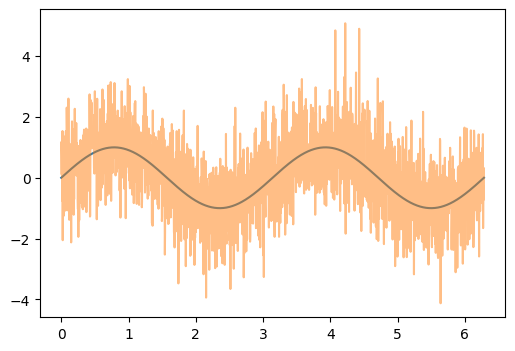

In [31]:
figsize(6, 4)
x = np.linspace(0, 2*np.pi, 2000)

y_gt = np.sin(2*x)
deriv_gt = 2*np.cos(2*x)


y_noisy = y_gt + np.random.randn(*y_gt.shape)
plt.plot(x, y_gt)
plt.plot(x, y_noisy, alpha=0.5)

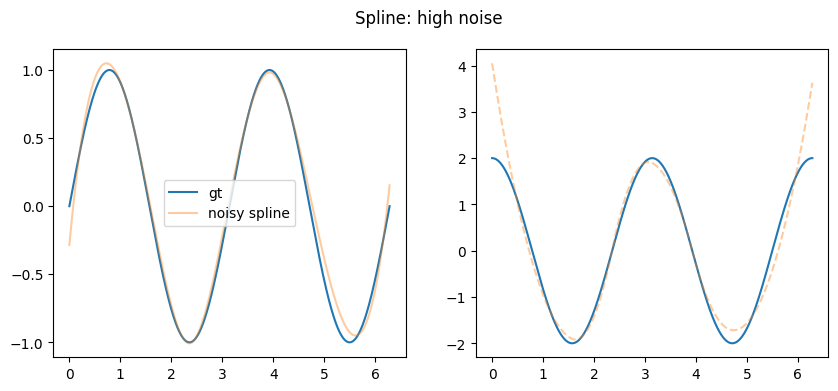

In [82]:
from scipy.interpolate import splev, splrep

myspline_noisy = splrep(x, y_noisy, s=2028)

figsize(10, 4)
plt.subplots(1,2)

plt.suptitle('Spline: high noise')

plt.subplot(1,2,1)
plt.plot(x, y_gt, label='gt')
plt.plot(x, splev(x, tck=myspline_noisy), label='noisy spline', alpha=0.4)
plt.legend()

plt.subplot(1,2,2)
plt.plot(x, deriv_gt)
plt.plot(x, splev(x, tck=myspline_noisy, der=1), '--', alpha=0.4)

Spline interpolation can perform well, but it is super sensitive to the level of regularization.

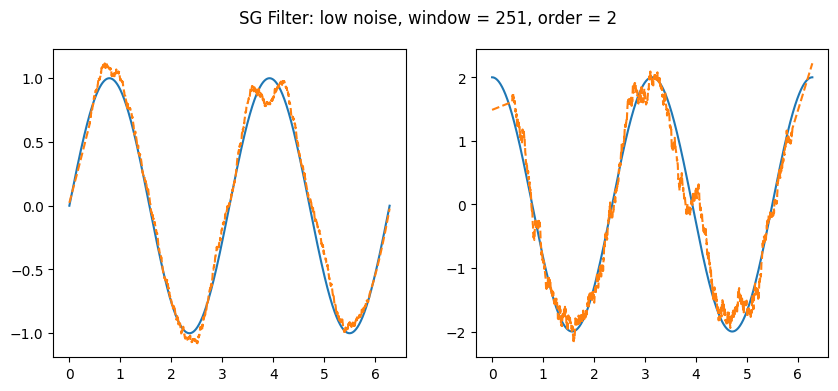

In [127]:
figsize(10, 4)
plt.subplots(1,2)

window = 251
order = 2

plt.suptitle(f'SG Filter: low noise, window = {window}, order = {order}')

plt.subplot(1,2,1)
plt.plot(x, y_gt)
plt.plot(x, savgol_filter(y_noisy, window_length=window, polyorder=order), '--')

plt.subplot(1,2,2)
plt.plot(x, deriv_gt, label='gt')
plt.plot(x, savgol_filter(y_noisy, window_length=window, polyorder=order, deriv=1, delta=x[2] - x[1]), '--', label='noisy_filtered')


At first, this looks less good because it is rough. However, the roughness doesn't really matter in the end, since we will be sampling anyway. 

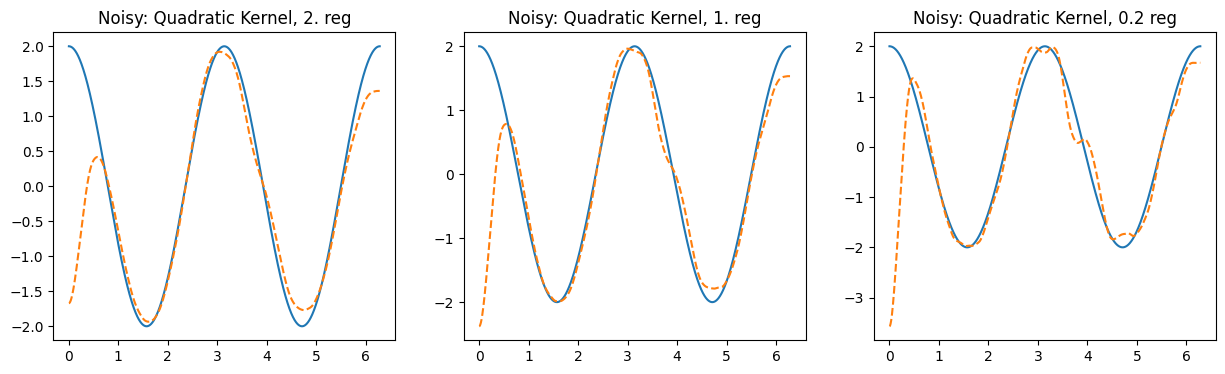

In [117]:
from tvregdiff.tvregdiff import TVRegDiff

figsize(15, 4)
plt.subplots(1,3)

plt.subplot(1,3,1)
fits = TVRegDiff(y_noisy, 400, 1., plotflag=False, diffkernel='sq', dx=(x[1] -x[0]) )
plt.title('Noisy: Quadratic Kernel, 2. reg')
plt.plot(x, deriv_gt)
plt.plot(x, fits,'--')

plt.subplot(1,3,2)
fits = TVRegDiff(y_noisy, 400, 0.5, plotflag=False, diffkernel='sq', dx=(x[1] -x[0]) )
plt.title('Noisy: Quadratic Kernel, 1. reg')
plt.plot(x, deriv_gt)
plt.plot(x, fits,'--')

plt.subplot(1,3,3)
fits = TVRegDiff(y_noisy, 400, 0.2, plotflag=False, diffkernel='sq', dx=(x[1] -x[0]) )
plt.title('Noisy: Quadratic Kernel, 0.2 reg')
plt.plot(x, deriv_gt)
plt.plot(x, fits,'--')

This is pretty nice too. Again, we would want to do the circle trick.

#### Summary, again

Honestly, any of these work for our purposes. No need to overthink things. The real challenge (as addressed in that paper) is to set the parameters.

In this sense, the SG filter is nice because the variation in the outputs gives some idea of how well the noise is being removed.

For the other methods, the 'circle trick', in which we serially change the midpoint, could be used to give an estimate of how much the outputs are varying.

__Conclusion:__ Just pick one! I'm actually leaning toward the SG filter. It seems like a reasonable approach, well established, and designed for this task w/ noise. The spline though... works for multibvariate data easily...

### Foreward


In [3]:
angles = np.linspace(0, np.pi, 10000)

noisy_results = trained_model.forward(
                            generateGrating(angles, pixelDim=pixelDim, shotNoise=shotNoise,
                                            noiseVar=noiseVar)
                    )

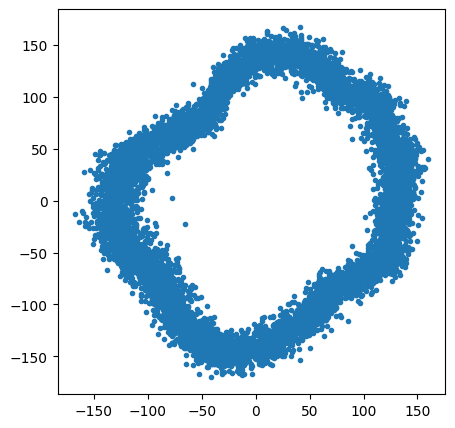

In [4]:
figsize(5,5)
plt.plot(noisy_results[:,0].detach().numpy(), noisy_results[:,1].detach().numpy(), '.')

Surely this is enought to get a reasonable estimate?